[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KDSource/KDSource/blob/master/docs/source/Tutorial.ipynb)

# Translation and rotation of particle lists

In this example we will translate and rotate a particle list using the KDSource tool.

Since KDSource objects allow translating and rotating particles while resampling, it is also possible to turn off the KDE method and use KDSource only for translating and rotating particles and saving them in a new transformed particle list.

## Install KDSource

First of all, we install KDSource on the Google Colab virtual machine. Estimated time: 1 min

Skip this cell if KDSource is already installed and available in your PATH (installation instructions [here](https://kdsource.readthedocs.io/en/latest/installation.html)).

In [ ]:
def install_kdsource():
    #
    # Clone source code from Github, make and install
    #
    
    import os
    
    if not os.path.isdir('/content'):
        print("This function installs KDSource in a Google Colaboratory instance.")
        print("For local installation instructions see:")
        print("https://kdsource.readthedocs.io/en/latest/installation.html")
        return
    
    %cd -q /content
    print("Obtaining KDSource source code from Github...")
    !git --no-pager clone --recurse-submodules https://github.com/KDSource/KDSource &> /dev/null
    %cd -q KDSource
    !git --no-pager checkout master &> /dev/null
    !mkdir build
    %cd -q build
    print("Running cmake...")
    !cmake .. -DCMAKE_INSTALL_PREFIX=/usr/local/KDSource &> /dev/null
    print("Running make install...")
    !make install &> /dev/null
    print("Installing Python API...")
    %cd -q ../python
    !pip install . &> /dev/null
    
    os.environ['PATH'] += ":/usr/local/KDSource/bin"
    
    %cd -q /content

from time import time
t1 = time()
install_kdsource()
t2 = time()
print("Installed KDSource in {:.2f} minutes".format((t2-t1)/60.0))


## Import required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

import kdsource as kds
import mcpl

## Load and inspect the original particle list

We have a particle list recorded as a MCPL file called `surf_source.mcpl.gz`, in the same folder than this Notebook, `docs/tutorial`. With the MCPL Python library we can load it and get basic statistical info and plots.

------------------------------------------------------------------------------
nparticles   : 1000
sum(weights) : 538.672
------------------------------------------------------------------------------
             :            mean             rms             min             max
------------------------------------------------------------------------------
ekin   [MeV] :     0.000639233       0.0141608      9.0346e-10         0.33598
x       [cm] :        -118.385          4.7438         -127.92         -109.17
y       [cm] :         103.305         11.7414          79.699          126.11
z       [cm] :        -5.14267         12.4827         -30.257          20.265
ux           :       -0.734509        0.253433       -0.999681         0.22835
uy           :        0.308736        0.367181       -0.911873        0.999415
uz           :     -0.00122694        0.407587       -0.983487         0.98415
time    [ms] :         3.19725         2.24106      0.00019913          17.918
weight   

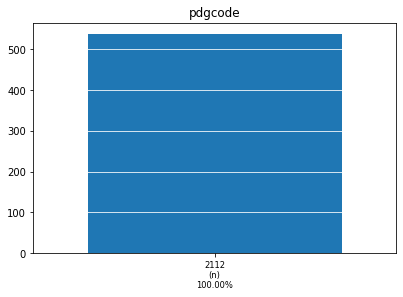

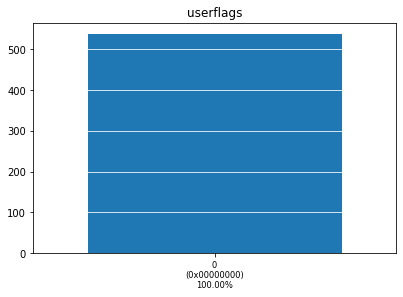

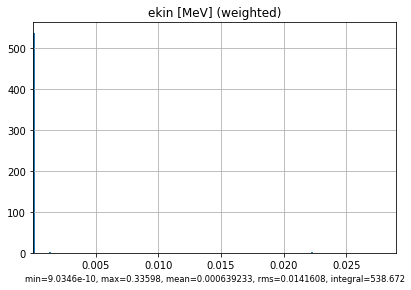

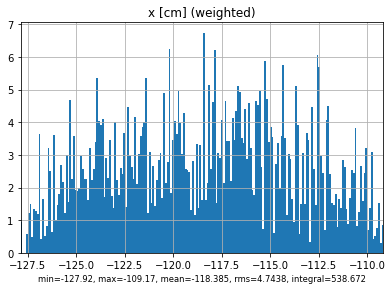

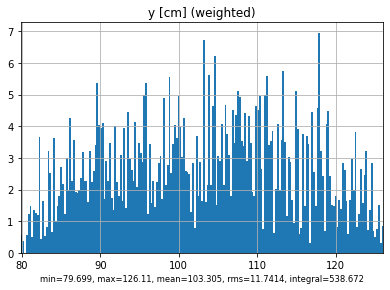

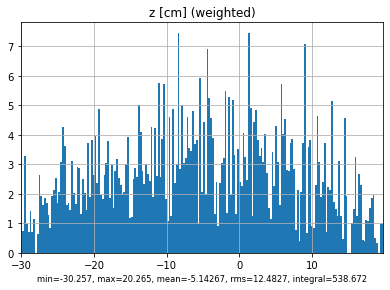

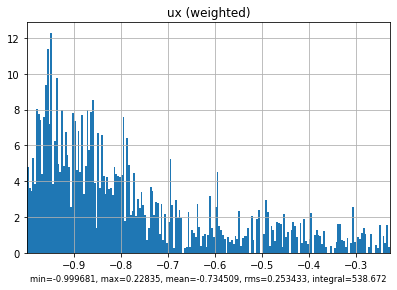

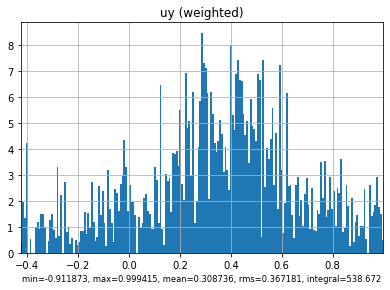

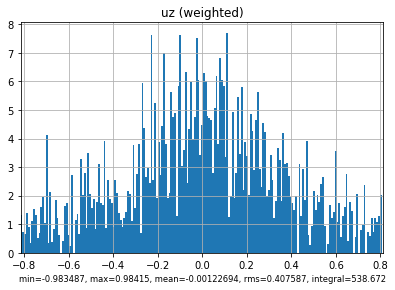

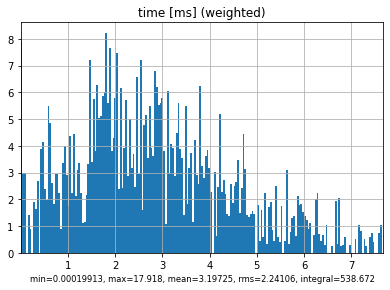

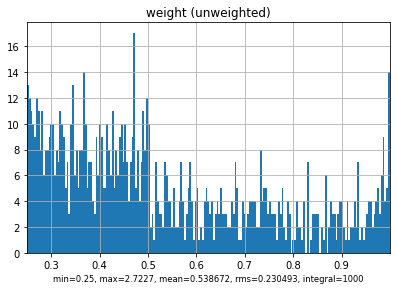

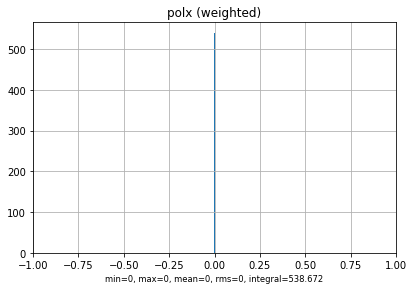

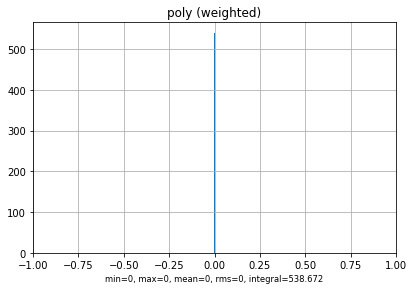

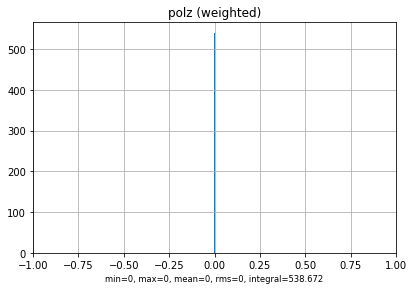

In [2]:
%matplotlib inline

surf_source = "surf_source.mcpl.gz"
mcpl.dump_stats(mcpl.collect_stats(surf_source))
mcpl.plot_stats(surf_source)

<IPython.core.display.Javascript object>


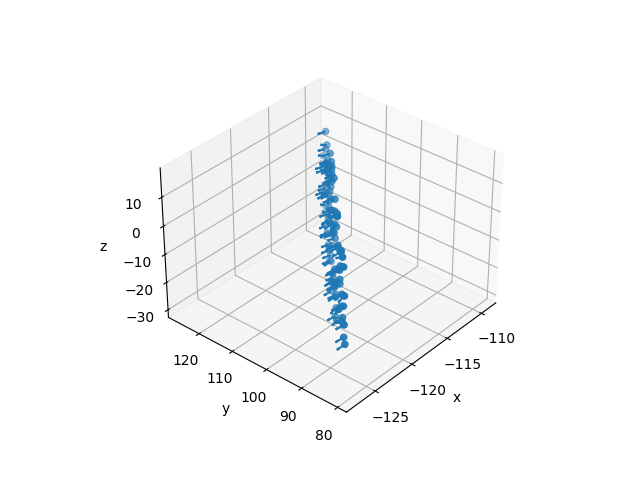

In [3]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

mcplsource = mcpl.MCPLFile(surf_source, blocklength=100)
block = mcplsource.read_block()

ax.scatter(*block.position.T)
ax.quiver(*np.array(block.position.T), *block.direction.T)
plt.show()

As we can see, the source is not aligned with the reference axis. In fact, it turns out that the source center is at x=-118.5497276, y=102.897199, z=-5.0, and that is rotated 158 degrees along the z axis.

We wish to have a source over the XY plane (i.e. with z=0), and with particles traveling towards the z positive direction.

Let's transform it!

## Translate and rotate using KDSource

### Create KDSource

When defining the PList object, we can specify a translation and rotation that will be applied to every particle inmediatly after reading it from the list, both with the Python API and with the C API while resampling.

With that translation and rotation we can bring the particle back to the main axis.

Nevertheless, given the particular orientation of these source, it is much easier rotating it to the YZ plane than to the XY plane. Luckily there is also an argument `switch_x2z` that, if True, applies the transformation (x,y,z) -> (y,z,x) after the translation and rotation.

We will not pay much attention to the bandwidth optimization since we will not apply KDE method.

In [4]:
# Create PList object with translation and rotation

plistfile = "surf_source.mcpl.gz"
plistformat = "mcpl"
pt = 'n'                                          # Particle type (n: neutron, p: photon)
trasl = [118.5497276, -102.897199, 5.0]           # Translation vector
rot = R.from_rotvec([0.0, 0.0, -158*np.pi/180.0]) # Rotation vector (axis-angle format)
x2z = True                                        # Apply (x,y,z) -> (y,z,x)

plist = kds.PList(plistfile, plistformat, pt=pt, trasl=trasl, rot=rot, switch_x2z=x2z)

# Create Geometry object

geom = kds.geom.GeomFlat(trasl=trasl, rot=rot)

# Create KSource and fit with default Silverman method

s = kds.KDSource(plist, geom)
s.fit()

Using existing file surf_source.mcpl.gz
sum_weights = 538.6724902689457
p2 = 343.29518043315363
N = 1000
N_eff = 845.2435930106187
Using 1000 particles for fit.
Calculating bw ... 
Done
Optimal bw (silv) = [[0.7527344  6.00056052 5.95801673 0.17504913 0.17504913 0.17504913]]


## Save KDSource model and resample without KDE method

We now save our optimized model as a KDSource XML file, and resample all particles in the list with the `--no-perturb` flag.

In [5]:
xmlfile = "source.xml" # KDSource XML file name
plistfile_tr = "surf_source_tr"

xmlfile = s.save(xmlfile)

!kdtool resample "$xmlfile" -o $plistfile_tr -n $s.plist.N --no-perturb

Successfully saved parameters file source.xml
Reading xmlfile source.xml...
Done.
Resampling...
MCPL: Attempting to compress file surf_source_tr.mcpl with gzip
MCPL: Succesfully compressed file into surf_source_tr.mcpl.gz
Successfully sampled 1000 particles.


## Load and inspect transformed particle list

We have successfully translated and rotated our particle list!

We can now load the transformed particle list and compare it with the original.

------------------------------------------------------------------------------
nparticles   : 1000
sum(weights) : 1000
------------------------------------------------------------------------------
             :            mean             rms             min             max
------------------------------------------------------------------------------
ekin   [MeV] :     0.000361218       0.0106419      9.0346e-10         0.33598
x       [cm] :       -0.365777         12.8653        -25.0362         24.9793
y       [cm] :     -0.00507184         12.3372         -25.257          25.265
z       [cm] :    -1.60664e-05      0.00281836     -0.00592316      0.00600731
ux           :     -0.00910573        0.387815       -0.955377        0.969421
uy           :     -0.00360428        0.398127       -0.983487         0.98415
uz           :        0.803049        0.214733        0.109885        0.999961
time    [ms] :         3.23441         2.26512      0.00019913          17.918
weight      

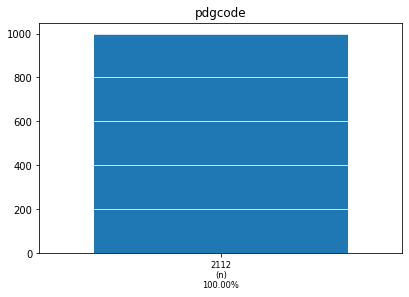

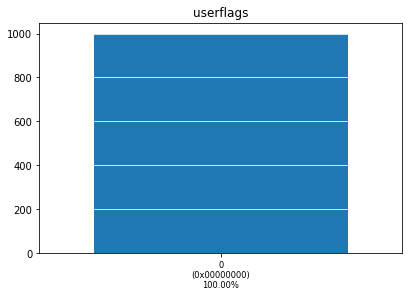

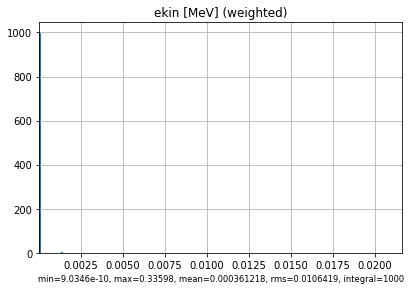

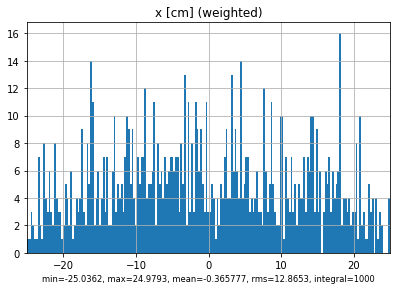

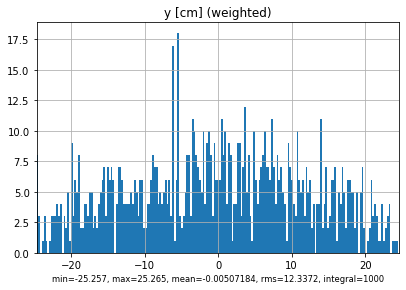

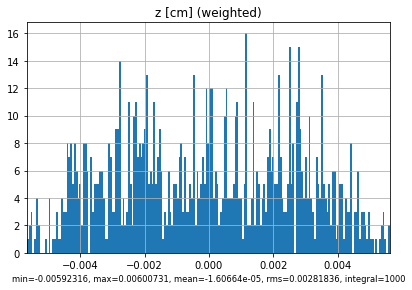

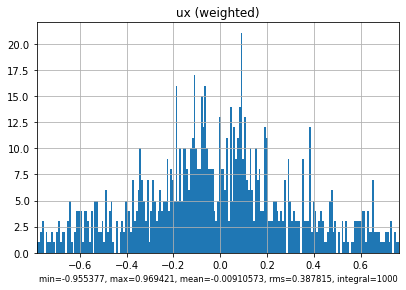

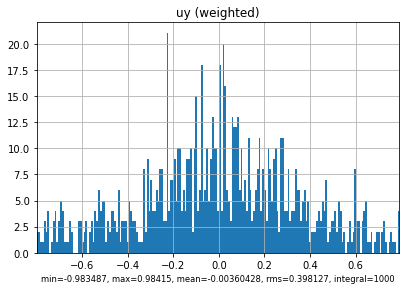

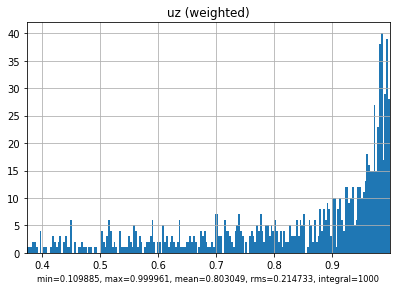

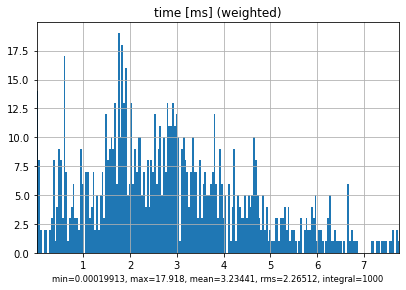

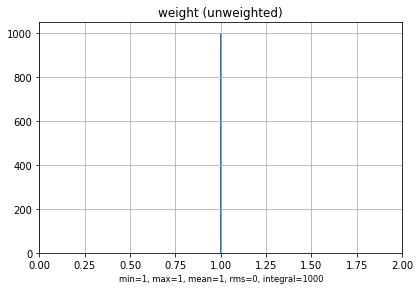

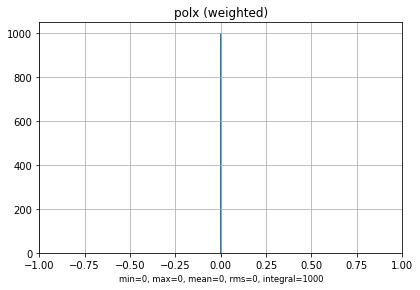

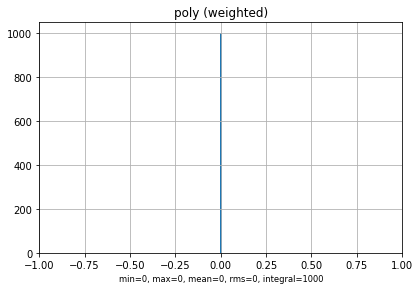

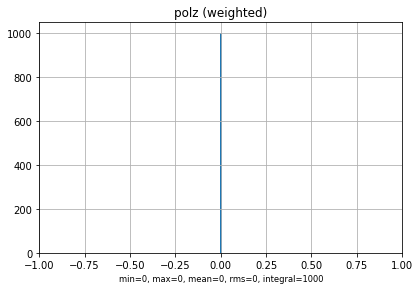

In [6]:
%matplotlib inline

surf_source_tr = "surf_source_tr.mcpl.gz"
mcpl.dump_stats(mcpl.collect_stats(surf_source_tr))
mcpl.plot_stats(surf_source_tr)

<IPython.core.display.Javascript object>


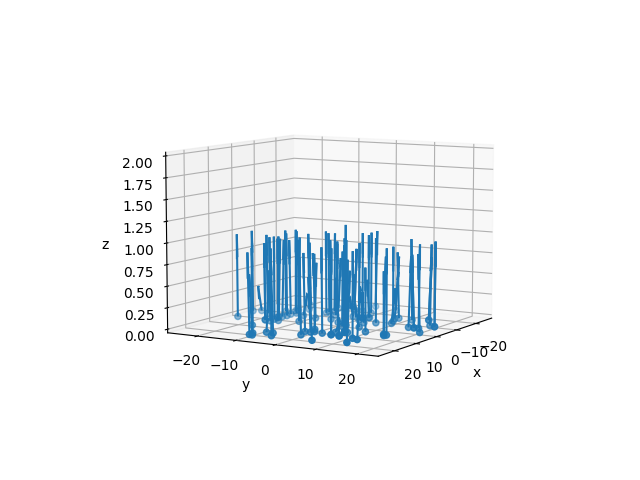

In [7]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_zlim(0,2)

mcplsource = mcpl.MCPLFile(surf_source_tr, blocklength=100)
block_tr = mcplsource.read_block()

ax.scatter(*block_tr.position.T)
ax.quiver(*np.array(block_tr.position.T), *block_tr.direction.T)
plt.show()

<IPython.core.display.Javascript object>


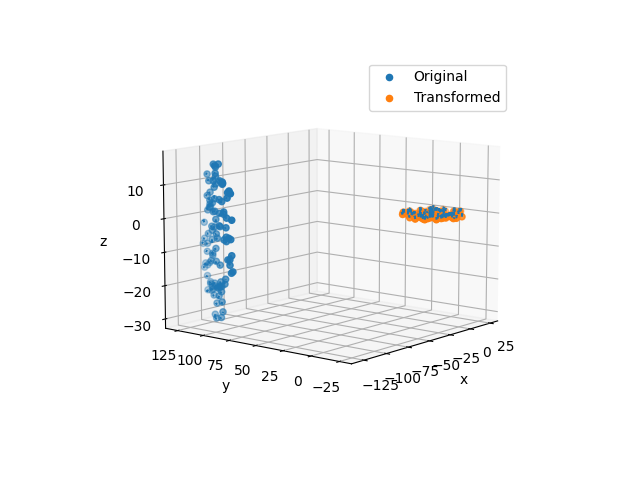

In [8]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(*block.position.T, label="Original")
ax.quiver(*np.array(block.position.T), *block.direction.T)

ax.scatter(*block_tr.position.T, label="Transformed")
ax.quiver(*np.array(block_tr.position.T), *block_tr.direction.T)
           
plt.legend()
plt.show()